作者信息说明：  
@Time : 2022年12月9日  
@Author : 郭学成  
@Email : 2723162295@qq.com  
@File : 淘宝用户行为分析源码.ipynb  
@Software: jupyter notebook  

# 1.淘宝用户流量分析

## 1.1	分析用户2017.11.25-2017.12.03的总pv和总uv

In [1]:
# 导入第三方计算包
import pandas
import pandas as pd

In [2]:
# 初始化数据（读取文件、为csv文件中的数据添加列名，将时间戳换成标准时间格式 Y-M-D）
def initialize_data(bool_strftime=True):
    data = pandas.read_csv(r"..\dataset\UserBehavior_removed_exception_data.csv")
    data.columns = list(["用户ID", "商品ID", "商品类目ID", "用户行为", "时间"])
    if bool_strftime:
        data['时间'] = data['时间'].map(lambda x: pd.Timestamp(x, unit="s").strftime("%Y-%m-%d"))
    else:
        data['时间'] = data['时间'].map(lambda x: pd.Timestamp(x, unit="s").strftime("%Y-%m-%d %H:%M:%S"))
    return data

In [3]:
# uv : (unique visitor)独立访客，即访问您网站的一台电脑客户端为一个访客。
# pv : (page view)页面浏览（点击）量，即用户每1次对网站中的每个网页访问均被记录1次。
# 获取用户将近一个月的pv和uv
def get_pv_uv_one_month():
    data = initialize_data()
    print(data.groupby(['用户行为'])['用户ID'].count()) # 获取用户的四种行为数量
    print("uv\t",data.groupby(['用户ID']).count().shape[0])  # 获取用户数量(uv)

In [4]:
# 打印结果
get_pv_uv_one_month()

用户行为
buy      2015839
cart     5530446
fav      2888258
pv      89660687
Name: 用户ID, dtype: int64
uv	 987991


**根据统计结果：pv：89660687（约9千万浏览量） uv:987991(约100万独立访客数)**

## 1.2	分析2017.11.25-2017.12.03时间内，每天的pv和uv

In [5]:
# 获取将近一个月内，每天的pv和uv,返回DataFrameGroupBy对象
def get_pv_uv_each_day(bool_strftime1=True):
    data = initialize_data(bool_strftime=bool_strftime1)
    each_day_pv_count = data.groupby(['时间',"用户行为"])["用户ID"]
    each_day_uv_count = data.groupby(['时间'])["用户ID"]
    return each_day_pv_count, each_day_uv_count

In [6]:
# 打印结果,只展示了前几行数据
pv1, uv1 = get_pv_uv_each_day(bool_strftime1=True)

In [7]:
pv1.count().unstack().head()

用户行为,buy,cart,fav,pv
时间,,,,
2017-11-24,16863,64328,35722,1064517
2017-11-25,201298,569236,305814,9435257
2017-11-26,214314,575420,305722,9475590
2017-11-27,218402,539212,289413,8966430
2017-11-28,211757,533807,289431,8849194


In [8]:
# 打印结果,只展示了前几行数据
uv1.nunique().head()

时间
2017-11-24    164703
2017-11-25    705571
2017-11-26    713522
2017-11-27    709207
2017-11-28    708339
Name: 用户ID, dtype: int64

**每天的uv，pv数据在上方展示（只展示了前几行数据），下面将每日uv，pv数据可视化**

In [9]:
import matplotlib
import matplotlib.pyplot as  plt
from matplotlib import ticker


# DataFrame类型自带了plot()绘制函数
def plt_uv_pv_each_day(pv1, uv1):
    #设置字体为楷体
    matplotlib.rcParams['font.sans-serif'] = ['KaiTi']
    # pv1, uv1 = get_pv_uv_each_day()
    # 这里的pv1包含的四种行为，这时,
    #  组内操作的结果不是单个值, 是一个序列, 我们可以用.unstack()将它展开
    pv2 = pv1.count().unstack()["pv"]
    uv2 = uv1.nunique()
    
    fig, ax = plt.subplots(1, 1)
    # 设置 x 轴显示密度
    tick_spacing = 2
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    # 设置 x 坐标轴标签的显示内容和大小
    plt.xlabel('时间', fontsize=15)
    plt.ylabel('次数', fontsize=15)
    # 设置 x 坐标轴刻度的旋转方向和大小
    # rotation: 旋转方向
    pv2.plot(legend=True,figsize=(20,10))
    uv2.plot(legend=True,figsize=(20,10))
    plt.xticks(rotation=90, fontsize=12)

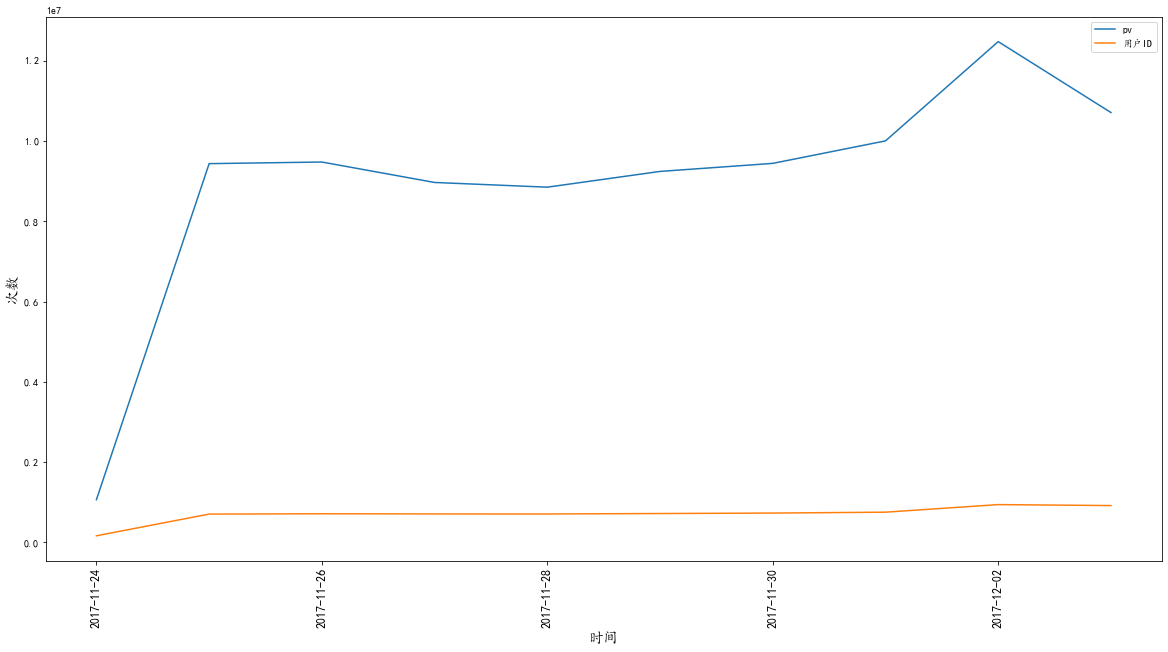

In [10]:
# 每日独立访客数（uv），浏览量（pv）数据,结果如下
plt_uv_pv_each_day(pv1, uv1)

**小结：观察到淘宝每天的访客数基本稳定在100万左右，说明淘宝的日活跃用户基数大。**

# 2. 用户消费行为分析

## 2.1	时间维度分析用户消费行为习惯

**(1)每天不同时刻的用户行为（buy,cart,fav,pv）--这里只随机选取三天（非活动日）分析**

In [11]:
data = initialize_data(bool_strftime=False)
data.tail()

,用户ID,商品ID,商品类目ID,用户行为,时间
100095225,999999,4797808,11120,pv,2017-12-03 09:30:03
100095226,999999,4613472,4602841,pv,2017-12-03 09:36:06
100095227,999999,3647364,2304296,pv,2017-12-03 09:36:32
100095228,999999,1903801,2304296,pv,2017-12-03 09:37:07
100095229,999999,3696094,4602841,pv,2017-12-03 09:38:11


In [12]:
# 选取两天时间分析每天的不同时刻用户行为流量
open_day='2017-11-28'
close_day='2017-11-30'
con1=data['时间']>=open_day
con2=data['时间']<close_day
data = data[con1&con2]
data.head()

,用户ID,商品ID,商品类目ID,用户行为,时间
14,1,5002615,2520377,pv,2017-11-28 03:23:05
15,1,2734026,4145813,pv,2017-11-28 04:09:44
16,1,5002615,2520377,pv,2017-11-28 04:44:33
17,1,3239041,2355072,pv,2017-11-28 07:54:24
18,1,4615417,4145813,pv,2017-11-28 12:07:44


In [13]:
data['时间'] = pd.to_datetime(data['时间'])

In [14]:
#用户四种行为各自的记录
pv_data=data[data['用户行为']=='pv']
cart_data=data[data['用户行为']=='cart']
collect_data=data[data['用户行为']=='fav']
buy_data=data[data['用户行为']=='buy']

In [15]:
#每个时刻四种行为数据量
pv_data1 = pv_data.set_index(['时间']).resample(rule='1H')['用户行为'].count()
cart_data1 = cart_data.set_index(['时间']).resample(rule='1H')['用户行为'].count()
collect_data1 = collect_data.set_index(['时间']).resample(rule='1H')['用户行为'].count()
buy_data1 = buy_data.set_index(['时间']).resample(rule='1H')['用户行为'].count()

<AxesSubplot:xlabel='时间'>

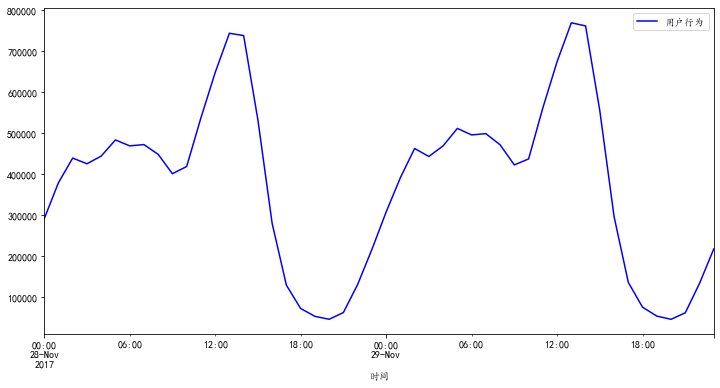

In [16]:
pv_data1.plot(legend=True,figsize=(12,6),color='blue')

<AxesSubplot:xlabel='时间'>

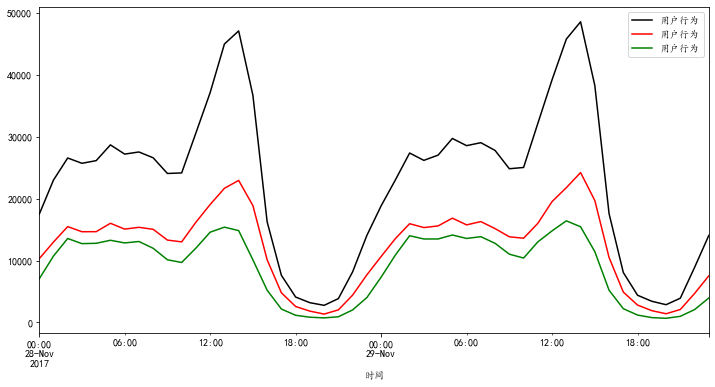

In [17]:
cart_data1.plot(legend=True,figsize=(12,6), color='black')
collect_data1.plot(legend=True,figsize=(12,6),color='red')
buy_data1.plot(legend=True,figsize=(12,6),color='green')
# plt.xticks(rotation=90, fontsize=12)

**小结 ：选取了11月28号（周二）和28号（周三），根据上图所示，可知用户的逛淘宝时间与人的作息时间基本一致。13：00-14：00之间浏览量达到最高值，随后开始下降，到19：00-20：00之间下降到最低值，大部分人在21：00之后又开始刷手机逛淘宝，人数一直增加，到02：00左右人数开始稳定，总结来说，该数据符合人的作息时间，尤其是上班族/学生。**

## 2.2	用户行为转化分析

“用户行为转化”定义：用户浏览商品详情页面，可以直接购买，也可以加购物车、收藏购买，用户收藏和加入购物车并没有必然的联系，不存在上下级，所以这里不画单一转化漏斗，而画出pv到成其他三种行为转化率的漏斗图。

In [18]:
import numpy as np
#用户发生四种行为每个行为的总数
behavior_funnel=data['用户行为'].value_counts().reset_index()
behavior_funnel.columns=['用户行为','pv']
# 求出单一环节转化率：
temp1 = np.array(behavior_funnel['pv'][1:])
temp2 = np.array(behavior_funnel['pv'][0:-1])
single_convs = list(temp1 / temp2)
single_convs.insert(0,1)
single_convs = [round(x,4) for x in single_convs] 
behavior_funnel['单一环节转化率'] = single_convs
#求出总体转化率
temp3 = np.array(behavior_funnel['pv'])
temp4= np.ones(len(behavior_funnel['pv'])) * behavior_funnel['pv'][0]
total_convs = (temp3 / temp4).tolist()
total_convs = [round(x,4) for x in total_convs]
behavior_funnel['总体转化率'] = total_convs
behavior_funnel

,用户行为,pv,单一环节转化率,总体转化率
0,pv,18090843,1.0000,1.0000
1,cart,1088554,0.0602,0.0602
2,fav,589019,0.5411,0.0326
3,buy,434839,0.7382,0.0240


In [19]:
#画用户行为总体转化漏斗图
import pyecharts.options as opts
from pyecharts.charts import Funnel
attrs = behavior_funnel['用户行为'].tolist()
values = (np.array(behavior_funnel['总体转化率'])* 100).tolist()  #586120
d = [[attrs[i], values[i]] for i in range(len(attrs))]
funnel=(
    Funnel(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add(
        series_name="",
        data_pair=d,
        gap=2,
        label_opts=opts.LabelOpts(is_show=True, position="inside",formatter="{c}%"),
        itemstyle_opts=opts.ItemStyleOpts(border_color="#fff", border_width=1),
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="用户行为总体转化漏斗图"))
)
funnel.render_notebook()


一、转化率低的可能原因分析：

（1）可能是用户不能够搜索到自己想要的东西导致的，因为有时候当用户输入关键词后，返回的页面是和关键词相关的一些商品，并非用户想要的。当然这是对于某些特定的商品而言，在淘宝上搜索宝贝，会搜索出一大堆无关东西。  

（2）可能是商品页面的描述信息或者首页展示图片比较拉跨，用户看了就划走了。  

（3）可能是用户自身需求临时改变的原因，因为人的消费具有即时性和冲动性，可能昨天晚上逛淘宝想买一大堆吃的，然后浏览了一大堆商品后添加了部分商品到购物车，第二天发现好像又没那么想要了，消费的冲动时间已经过去了。  

（4）也可能是物流原因，有些商品需要很快到手就用的，这种受物流影响比较大，比如在淘宝买书，每天就要用，这时候用户可能会跳转到京东上购买。  

二、优化环节建议  

（1）首先是商铺的页面要设计的吸引人，同时要和卖的商品主题相关，最好不要挂羊头卖狗肉，很容易引起消费者的吐槽和不满。  

（2）其次是物流方面，越快越好，同时不能使商品有损坏。   

（3）把握好消费者逛淘宝的时间，同时当消费者对商品感兴趣（就算收藏或者已经添加到购物车了），如果消费者还在犹豫下单，可能是价格方面对于消费者不是特别友好，还在纠结中，这个时候需要商铺适当发一些优惠券或者红包折扣之类的，能够快速转化成交单。

**小结：由图可知，用户的浏览量到加入购物车，点击收藏，以及下单的转换率都很低，点击量转化为购买的行为转换率才2.48%，需要在多个环节进行优化**


## 2.3 月复购率

月复购率：一个月内购买次数超过k次的用户数与所有购买过的用户数(k值可调整，这里k=2)

In [20]:
pv_data.groupby('用户ID').count().count()      #访问记录用户数

商品ID      849841
商品类目ID    849841
用户行为      849841
时间        849841
dtype: int64

In [21]:
user_buy=data[data['用户行为']=='buy'].groupby('用户ID').count()
user_buy.count()            #有购买记录用户数

商品ID      252375
商品类目ID    252375
用户行为      252375
时间        252375
dtype: int64

In [27]:
user_buy[user_buy['用户行为'] >=2].count()   #购买次数超过2次的用户数

商品ID      94250
商品类目ID    94250
用户行为      94250
时间        94250
dtype: int64

In [28]:
#月复购率
94250/252375

0.37345220406141655

**小结：淘宝用户将近一个月的复购率为：37.35% ，可以看出用户粘性很高，用户非常喜欢用淘宝**

## 2.4 用户购买和不购买的路径分析

### (1) 购买的路径方式

In [29]:
#四种行为按商品分组
item_pv = pv_data.groupby('商品ID')['用户行为'].count().reset_index()
item_cart=cart_data.groupby('商品ID')['用户行为'].count().reset_index()
item_collect=collect_data.groupby('商品ID')['用户行为'].count().reset_index()
item_buy=buy_data.groupby('商品ID')['用户行为'].count().reset_index()
# 点击—购买
pd.merge(item_pv,item_buy,on='商品ID',how='inner').count()              #89786

商品ID      215227
用户行为_x    215227
用户行为_y    215227
dtype: int64

In [30]:
#点击—加购物车-购买
pv_cart=pd.merge(item_pv,item_cart,on='商品ID',how='inner')            
pd.merge(pv_cart,item_buy,on='商品ID',how='inner').count()              #61102

商品ID      125583
用户行为_x    125583
用户行为_y    125583
用户行为      125583
dtype: int64

In [31]:
#点击—收藏—购买
pv_collect=pd.merge(item_pv,item_collect,on='商品ID',how='inner')
pd.merge(pv_collect,item_buy,on='商品ID',how='inner').count()           #19869

商品ID      89484
用户行为_x    89484
用户行为_y    89484
用户行为      89484
dtype: int64

In [32]:
#点击—加购物车—收藏—购买
pv_cart_collect=pd.merge(pv_cart,item_collect,on='商品ID',how='inner')  
pd.merge(pv_cart_collect,item_buy,on='商品ID',how='inner').count()      #13892

商品ID      71765
用户行为_x    71765
用户行为_y    71765
用户行为_x    71765
用户行为_y    71765
dtype: int64

### (2) 不购买的路径方式

In [44]:
#不购买行为按商品分组
# item_nobuy=data[data['用户行为'].isin(['pv','fav','cart'])].groupby('商品ID')['用户行为'].count().reset_index
item_nobuy=data[data['用户行为'].isin(['pv','fav','cart'])].groupby('商品ID')['用户行为'].count()
item_nobuy.head()

商品ID
1    1
3    1
5    1
7    2
8    1
Name: 用户行为, dtype: int64

In [45]:
# 点击—不购买
# pd.DataFrame(pd.merge(item_pv,item_nobuy,on='商品ID',how='inner'))#2870604
pd.merge(item_pv,item_nobuy,on='商品ID',how='inner').head()

,商品ID,用户行为_x,用户行为_y
0,1,1,1
1,3,1,1
2,5,1,1
3,7,2,2
4,8,1,1


In [35]:
#点击—加购物车-不购买
pv_cart=pd.merge(item_pv,item_cart,on='商品ID',how='inner')
pd.merge(pv_cart,item_nobuy,on='商品ID',how='inner').count()            #247177

商品ID      433414
用户行为_x    433414
用户行为_y    433414
用户行为      433414
dtype: int64

In [36]:
#点击—收藏—不购买
pv_collect=pd.merge(item_pv,item_collect,on='商品ID',how='inner')
pd.merge(pv_collect,item_nobuy,on='商品ID',how='inner').count()         #204117

商品ID      294883
用户行为_x    294883
用户行为_y    294883
用户行为      294883
dtype: int64

In [37]:
#点击—加购物车—收藏—不购买
pv_cart_collect=pd.merge(pv_cart,item_collect,on='商品ID',how='inner')
pd.merge(pv_cart_collect,item_nobuy,on='商品ID',how='inner').count()    #38710

商品ID      161372
用户行为_x    161372
用户行为_y    161372
用户行为_x    161372
用户行为_y    161372
dtype: int64

# 3.商品销售情况分析

## 3.1 浏览量（pv）前十的商品

In [52]:
data.groupby('用户ID').count().shape[0]        #商品总数

867189

In [55]:
item_frequency=buy_data.groupby(['用户ID'],as_index=False).count()

In [57]:
item_frequency[item_frequency['用户行为'] >=1 ].count()   #销售1次及以上的商品数
item_frequency.count()    #销售的商品数

用户ID      252375
商品ID      252375
商品类目ID    252375
用户行为      252375
时间        252375
dtype: int64

In [58]:
252375/867189

0.291026523629797

**小结：总共的商品数量是867189个(约86万)，销售1次及以上的商品是252375个（约25万），占比29.1%， 可以考虑将销量高的产品捆绑销量低的产品（再给一些优惠），能够提升销量降低库存，提高商品被买的概率**

## 3.2 购买量（buy）前十的商品

In [41]:
#pv前10的商品
pv_item=pv_data.groupby('商品ID').count().sort_values(by="用户ID" , ascending=False)[:10]
pv_item['用户行为']

商品ID
812879     6164
3845720    5383
987143     4848
2032668    4079
59883      4033
138964     3742
4211339    3701
2331370    3517
3031354    3258
2818406    3193
Name: 用户行为, dtype: int64

In [42]:
#购买量前10的商品
buy_item=buy_data.groupby('商品ID').count().sort_values(by="用户ID" , ascending=False)[:10]
buy_item['用户行为']

商品ID
3122135    788
4499425    341
3879906    220
4260261    217
3412803    174
3237415    169
3031354    169
3964583    156
2621260    143
4554918    143
Name: 用户行为, dtype: int64

In [43]:
#pv前10和购买量前10中都有的商品
pv_item_list=list(pv_item.index)
buy_item_list=list(buy_item.index)
same_item= list(set(buy_item_list) & set(pv_item_list))
same_item                      #pv前10和购买]\\量前10中都有的商品只有一个：[3031354]

[3031354]

# 4. 总结

(1)用户逛淘宝习惯与人的作息工作时间基本一致，在用户空闲时间.

建议：在用户收藏/加入购物车的一段时间内，考虑适当发一些优惠券

(2)用户购买、不购买的路径大多数都是浏览商品直接购买或者流失。

建议：优化页面，设计页面的时候要贴合商品，同时要设计的美观

(3)加购物车和收藏到购买的转化率相比于pv到购买比较可观，应关注加购物车和收藏的商品

建议：推送优惠券，提高推荐系统的精确度

(4)用户月复购率也较高,对平台的粘性和忠诚度较高

建议：保持平台的不断更新迭代，顺应时代的发展，不要固步自封，长时间停留在原地

(5)pv到购买的转化率偏低，且浏览量前十商品和购买量前十商品中相同的商品较少，说明用户花了大量的时间选择合适的商品

建议：提高搜索、检索的准确度，优化推荐系统性能以及算法。